# Segmentación RD - PyTorch
## U-Net, FPN, U-Net++, DeepLabV3+ con Máscaras Multicanal

**MEJORAS IMPLEMENTADAS desde VGG16-UNet:**
- ✅ **Máscaras MULTICANAL** (6 canales independientes, permite overlaps)
- ✅ **200 steps/epoch** (14× más datos por época)
- ✅ **Class Weights VGG16** ([0.5, 6.0, 4.0, 2.0, 4.0, 1.0])
- ✅ **Loss Multicanal** (Dice + BCE por canal)
- ✅ **Augmentation con CLAHE**
- ✅ **VGG16 encoder disponible**
- ✅ **Fine-tuning completo**

## PASO 1: Instalación

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q segmentation-models-pytorch
!pip install -q albumentations==1.3.1
!pip install -q opencv-python-headless
!pip install -q timm
!pip install -q tqdm matplotlib

print("✅ Instalación completada")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 9.8 MB/s eta 0:00:00
✅ Instalación completada


## PASO 2: Importaciones y Configuración

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
from pathlib import Path
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

# CONFIGURACIÓN GLOBAL
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# HIPERPARÁMETROS (basados en VGG16)
IMG_SIZE = 1024              # Carga en alta resolución
PATCH_SIZE = 512             # Patches de 512×512
BATCH_SIZE = 4               # VGG16 usa 4
NUM_CLASSES = 6              # Background + 5 lesiones
EPOCHS = 50                  # VGG16 usó 44
LEARNING_RATE = 1e-4         # VGG16 inicial
WEIGHT_DECAY = 1e-4
RANDOM_SEED = 42

# CRÍTICO: Steps per epoch como VGG16
STEPS_PER_EPOCH = 200        # VGG16 usa 200
VAL_STEPS = 50               # VGG16 usa 50

# ARQUITECTURA (cambiar según necesites)
ARCHITECTURE = 'unet'        # Opciones: 'unet', 'fpn', 'unetplusplus', 'deeplabv3plus'
ENCODER = 'efficientnet-b3'            # VGG16 como baseline (también: 'efficientnet-b3')

# Sufijos de archivo para cada lesión según IDRiD (ej: IDRiD_01_MA.tif)
LESION_SUFFIXES = {
    'MA': '_MA.tif',
    'HE': '_HE.tif',
    'EX': '_EX.tif',
    'SE': '_SE.tif',
    'OD': '_OD.tif'
}

# Seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"\n✅ Configuración:")
print(f"   Arquitectura: {ARCHITECTURE}")
print(f"   Encoder: {ENCODER}")
print(f"   Steps/epoch: {STEPS_PER_EPOCH}")
print(f"   Patch size: {PATCH_SIZE}")

🔧 Dispositivo: cuda
   GPU: Tesla T4
   Memoria: 15.83 GB

✅ Configuración:
   Arquitectura: unet
   Encoder: efficientnet-b3
   Steps/epoch: 200
   Patch size: 512


## PASO 3: Funciones de Carga de Datos (Máscaras Multicanal)

In [ ]:
def load_idrid_data_multichannel(img_dir, lesion_folders, img_size=(IMG_SIZE, IMG_SIZE)):
    """
    Carga datos con máscaras MULTICANAL

    CRÍTICO: Retorna máscaras con shape (N, H, W, 6) donde cada canal
    es independiente, permitiendo overlaps de lesiones.

    Returns:
        X: (N, H, W, 3) - imágenes RGB normalizadas [0, 1]
        Y: (N, H, W, 6) - máscaras multicanal [0, 1] (float32)
    """
    X = []
    Y = []

    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    print(f"🔄 Cargando {len(image_files)} imágenes desde {img_dir}...")

    for img_name in tqdm(image_files, desc="Cargando datos"):
        # 1. Cargar imagen
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalizar [0, 1]
        X.append(img)

        # 2. Construir máscara MULTICANAL
        base_name = img_name.replace('.jpg', '')
        lesion_keys = ['MA', 'HE', 'EX', 'SE', 'OD']
        lesion_masks = []

        for lesion_type in lesion_keys:
            folder = lesion_folders.get(lesion_type)
            if not folder:
                lesion_masks.append(np.zeros(img_size, dtype=np.float32))
                continue

            # Buscar archivo
            candidates = [
                f"{base_name}_{lesion_type}.tif",
                f"{base_name}.tif"
            ]

            mask = None
            for filename in candidates:
                mask_path = os.path.join(folder, filename)
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
                        # Convertir a binario [0, 1] float
                        mask = (mask > 0).astype(np.float32)
                    break

            if mask is None:
                mask = np.zeros(img_size, dtype=np.float32)

            lesion_masks.append(mask)

        # Stack lesiones: (5, H, W)
        lesion_masks = np.stack(lesion_masks, axis=0)

        # 3. Calcular Background (canal 0)
        # Background = 1 donde NO hay ninguna lesión
        all_lesions = np.sum(lesion_masks, axis=0)  # (H, W)
        background = np.where(all_lesions == 0, 1.0, 0.0).astype(np.float32)

        # 4. Concatenar: [BG, MA, HE, EX, SE, OD]
        # Shape final: (6, H, W)
        final_mask = np.concatenate([
            background[np.newaxis, :, :],  # (1, H, W)
            lesion_masks                    # (5, H, W)
        ], axis=0)

        # Transponer a (H, W, 6) para compatibilidad
        final_mask = np.transpose(final_mask, (1, 2, 0))
        Y.append(final_mask)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)


def get_lesion_coordinates(Y_data):
    """
    Mapea coordenadas de lesiones para sampling inteligente.

    Args:
        Y_data: (N, H, W, 6) - máscaras multicanal

    Returns:
        coords: dict {idx: array(M, 2)} - coordenadas (y, x) de lesiones
    """
    coords = {}
    print("📍 Mapeando coordenadas de lesiones...")

    for idx in tqdm(range(len(Y_data)), desc="Mapeando"):
        # Sumar canales 1-5 (ignorar background en canal 0)
        lesions = np.sum(Y_data[idx, :, :, 1:], axis=-1)
        ys, xs = np.where(lesions > 0)

        if len(ys) > 0:
            coords[idx] = np.column_stack((ys, xs))

    print(f"✅ Lesiones encontradas en {len(coords)}/{len(Y_data)} imágenes")
    return coords


def print_class_distribution(Y_data, title="Dataset"):
    """
    Imprime distribución de clases en máscaras multicanal.
    """
    print(f"\n{'='*60}")
    print(f"DISTRIBUCIÓN DE CLASES - {title}")
    print(f"{'='*60}")

    class_names = ['Background', 'MA', 'HE', 'EX', 'SE', 'OD']
    total_pixels = Y_data.shape[0] * Y_data.shape[1] * Y_data.shape[2]

    for class_id, class_name in enumerate(class_names):
        # Contar píxeles positivos en este canal
        count = np.sum(Y_data[:, :, :, class_id] > 0.5)
        percentage = 100 * count / total_pixels
        print(f"{class_name:12s}: {count:10d} píxeles ({percentage:5.2f}%)")

    print(f"{'='*60}\n")


print("✅ Funciones de carga definidas (MULTICANAL)")

✅ Funciones de carga definidas (MULTICANAL)


In [ ]:
import numpy as np
from tqdm import tqdm

# --- 1. MAPEO DE COORDENADAS ---
def get_lesion_coordinates(Y_data):
    """
    Genera un diccionario donde key=idx_imagen y value=lista de coordenadas (y,x)
    de píxeles que contienen CUALQUIER lesión (canales 1 a 5).
    """
    lesion_coords = {}
    N = Y_data.shape[0]

    print("Escaneando imágenes para encontrar lesiones...")
    for idx in tqdm(range(N)):
        # Sumamos canales 1-5 (MA, HE, EX, SE, OD). Ignoramos Fondo (0).
        # Nota: Y_data debe ser (N, H, W, 6)
        mask_lesions = np.sum(Y_data[idx, :, :, 1:], axis=-1)

        # Obtener coordenadas donde hay algo (valor > 0)
        ys, xs = np.where(mask_lesions > 0)

        # Si la imagen tiene lesiones, guardamos las coordenadas
        if len(ys) > 0:
            # Guardamos como lista de pares (y, x)
            coords = np.column_stack((ys, xs))
            lesion_coords[idx] = coords

    print(f"✅ Se encontraron lesiones en {len(lesion_coords)} de {N} imágenes.")
    return lesion_coords

# --- 2. GENERADOR ENFOCADO (HARD NEGATIVE MINING) ---
def lesion_aware_patch_generator(X_data, Y_data, lesion_coords, batch_size, patch_size, focus_ratio=0.7):
    """
    Genera parches.
    - 70% del tiempo: Centra el parche en una lesión real.
    - 30% del tiempo: Parche aleatorio (para aprender fondo).
    """
    N, H, W, C = X_data.shape
    num_classes = Y_data.shape[-1]

    # Pre-calcular límites para no salirnos de la imagen
    max_y = H - patch_size
    max_x = W - patch_size

    while True:
        batch_x = np.zeros((batch_size, patch_size, patch_size, C), dtype=np.float32)
        batch_y = np.zeros((batch_size, patch_size, patch_size, num_classes), dtype=np.uint8)

        for i in range(batch_size):
            # Elegir imagen aleatoria
            idx = np.random.randint(0, N)

            # Decidir estrategia: ¿Enfocado o Aleatorio?
            # Solo podemos enfocar si la imagen 'idx' tiene lesiones registradas
            is_focused = (np.random.rand() < focus_ratio) and (idx in lesion_coords)

            if is_focused:
                # --- ESTRATEGIA ENFOCADA ---
                # 1. Obtener todas las coordenadas de lesión de esta imagen
                coords = lesion_coords[idx]

                # 2. Elegir un punto de lesión al azar
                target_y, target_x = coords[np.random.randint(len(coords))]

                # 3. Calcular esquina superior izquierda para que 'target' quede en el centro aprox
                # Aleatorizamos un poco el centro para que no sea siempre el píxel exacto del medio
                y_start = target_y - np.random.randint(patch_size // 4, patch_size * 3 // 4)
                x_start = target_x - np.random.randint(patch_size // 4, patch_size * 3 // 4)

            else:
                # --- ESTRATEGIA ALEATORIA (FONDO) ---
                y_start = np.random.randint(0, max_y)
                x_start = np.random.randint(0, max_x)

            # --- CLIPPING (Seguridad) ---
            # Asegurar que las coordenadas estén dentro de la imagen válida
            y_start = np.clip(y_start, 0, max_y)
            x_start = np.clip(x_start, 0, max_x)

            # --- EXTRACCIÓN ---
            batch_x[i] = X_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]
            batch_y[i] = Y_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]

        yield (batch_x, batch_y)

## PASO 4: Dataset PyTorch con Máscaras Multicanal y Repetición

In [ ]:
class MultiChannelIDRiDDataset(Dataset):
    """
    Dataset con máscaras MULTICANAL y sampling como VGG16.
    """

    def __init__(self, images, masks, lesion_coords, patch_size=512,
                 transform=None, is_training=True, focus_ratio=0.6):
        """
        Args:
            images: (N, H, W, 3) - float32 [0, 1]
            masks: (N, H, W, 6) - float32 [0, 1] MULTICANAL
            focus_ratio: 0.6 como VGG16 (60% centrado en lesiones)
        """
        self.images = images
        self.masks = masks
        self.lesion_coords = lesion_coords
        self.patch_size = patch_size
        self.transform = transform
        self.is_training = is_training
        self.focus_ratio = focus_ratio

        self.n_samples = len(images)
        self.img_h, self.img_w = images.shape[1:3]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]  # (H, W, 6)

        # Sampling strategy (como VGG16)
        if self.is_training and idx in self.lesion_coords:
            # 60% probabilidad de centrar en lesión
            if np.random.rand() < self.focus_ratio:
                coords = self.lesion_coords[idx]
                center_y, center_x = coords[np.random.randint(len(coords))]

                # Añadir ruido al centrado (como VGG16)
                offset_y = np.random.randint(self.patch_size//4, self.patch_size*3//4)
                offset_x = np.random.randint(self.patch_size//4, self.patch_size*3//4)

                y1 = center_y - offset_y
                x1 = center_x - offset_x
            else:
                # Patch aleatorio
                y1 = np.random.randint(0, max(1, self.img_h - self.patch_size))
                x1 = np.random.randint(0, max(1, self.img_w - self.patch_size))
        else:
            # Validación: patch aleatorio
            y1 = np.random.randint(0, max(1, self.img_h - self.patch_size))
            x1 = np.random.randint(0, max(1, self.img_w - self.patch_size))

        # Clipping
        y1 = np.clip(y1, 0, self.img_h - self.patch_size)
        x1 = np.clip(x1, 0, self.img_w - self.patch_size)
        y2 = y1 + self.patch_size
        x2 = x1 + self.patch_size

        # Extraer patch
        patch_img = image[y1:y2, x1:x2]
        patch_mask = mask[y1:y2, x1:x2]  # (patch_size, patch_size, 6)

        # Augmentation
        if self.transform:
            augmented = self.transform(image=patch_img, mask=patch_mask)
            patch_img = augmented['image']
            patch_mask = augmented['mask']

        # patch_img: (3, H, W) tensor
        # patch_mask: (H, W, 6) tensor → convertir a (6, H, W)
        if not torch.is_tensor(patch_mask):
            patch_mask = torch.from_numpy(patch_mask)

        patch_mask = patch_mask.permute(2, 0, 1).float()  # (6, H, W)

        return patch_img, patch_mask


class RepeatedDataset(Dataset):
    """
    Wrapper para repetir dataset y alcanzar 200 steps/epoch como VGG16.

    VGG16 hace 200 steps × 4 batch = 800 patches/epoch
    Con 54 imágenes, necesitamos repetir ~14× para lograrlo.
    """

    def __init__(self, base_dataset, repeat_factor=14):
        self.base = base_dataset
        self.repeat = repeat_factor

    def __len__(self):
        return len(self.base) * self.repeat

    def __getitem__(self, idx):
        real_idx = idx % len(self.base)
        return self.base[real_idx]


print("✅ Dataset PyTorch definido (MULTICANAL + REPETICIÓN)")

✅ Dataset PyTorch definido (MULTICANAL + REPETICIÓN)


## PASO 5: Augmentations

In [ ]:
def float_to_uint8_image(image, **kwargs):
    return (image * 255).astype(np.uint8)

def uint8_to_float_image(image, **kwargs):
    return image.astype(np.float32) / 255.0

def identity_mask(mask, **kwargs):
    return mask

def get_training_augmentation_with_clahe(patch_size=512):
    """
    VERSIÓN AVANZADA: Con CLAHE (requiere conversiones).
    """
    return A.Compose([
        A.Resize(patch_size, patch_size),

        # Convertir float→uint8 para CLAHE
        A.Lambda(
            image=float_to_uint8_image,
            mask=identity_mask,
            name="float_to_uint8"
        ),

        # Geométricas (trabajan con uint8)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),

        # CLAHE
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),

        # Brillo/Contraste
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),

        # Convertir uint8→float
        A.Lambda(
            image=uint8_to_float_image,
            mask=identity_mask,
            name="uint8_to_float"
        ),

        # Normalización
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),

        ToTensorV2()
    ])


In [ ]:
def get_advanced_training_augmentation(patch_size=512):
    """
    VERSIÓN AVANZADA: Con CLAHE y otras transformaciones para lesiones.
    Uses named functions for Lambda to support multiprocessing.
    """
    return A.Compose([
        A.Resize(patch_size, patch_size),

        # Convertir float→uint8 para CLAHE y otras
        A.Lambda(
            image=float_to_uint8_image,
            mask=identity_mask, # Named function
            name="float_to_uint8"
        ),

        # Geométricas (trabajan con uint8)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),

        # CLAHE
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),

        # Brillo/Contraste
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),

        # Nuevas augmentations
        A.GaussNoise(p=0.2), # Gaussian noise
        A.FancyPCA(alpha=0.1, p=0.2), # Color augmentation
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.2), # Simulate occlusions
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2), # Elastic deformations

        # Convertir uint8→float
        A.Lambda(
            image=uint8_to_float_image,
            mask=identity_mask, # Named function
            name="uint8_to_float"
        ),

        # Normalización
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),

        ToTensorV2()
    ])

## PASO 6: Modelo con Sigmoid Activation (para Multicanal)

In [ ]:
def create_model_multichannel(architecture='unet', encoder='vgg16', num_classes=NUM_CLASSES):
    """
    Crea modelo con SIGMOID activation (NO softmax) para máscaras multicanal.

    CRÍTICO: sigmoid permite que cada canal sea independiente.
    """
    MODELS = {
        'unet': smp.Unet,
        'fpn': smp.FPN,
        'unetplusplus': smp.UnetPlusPlus,
        'deeplabv3plus': smp.DeepLabV3Plus
    }

    if architecture not in MODELS:
        raise ValueError(f"Arquitectura debe ser: {list(MODELS.keys())}")

    print(f"\n{'='*60}")
    print(f"CREANDO MODELO (MULTICANAL)")
    print(f"{'='*60}")
    print(f"Arquitectura: {architecture}")
    print(f"Encoder: {encoder}")
    print(f"Classes: {num_classes}")
    print(f"Activation: SIGMOID (permite overlaps)")

    model = MODELS[architecture](
        encoder_name=encoder,
        encoder_weights='imagenet',
        in_channels=3,
        classes=num_classes,
        activation='sigmoid'  # NO usar 'softmax'
    )

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nParámetros totales: {total_params/1e6:.2f}M")
    print(f"Parámetros entrenables: {trainable_params/1e6:.2f}M")
    print(f"{'='*60}\n")

    return model


# Test rápido
print("🧪 Test de creación de modelo...")
test_model = create_model_multichannel(ARCHITECTURE, ENCODER)
test_model.eval()
test_input = torch.randn(1, 3, PATCH_SIZE, PATCH_SIZE)

with torch.no_grad():
    test_output = test_model(test_input)

print(f"✅ Forward pass exitoso")
print(f"   Input: {test_input.shape}")
print(f"   Output: {test_output.shape} (6 canales independientes)")
print(f"   Output range: [{test_output.min():.3f}, {test_output.max():.3f}] (sigmoid)")
del test_model, test_input, test_output

🧪 Test de creación de modelo...

CREANDO MODELO (MULTICANAL)
Arquitectura: unet
Encoder: efficientnet-b3
Classes: 6
Activation: SIGMOID (permite overlaps)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Parámetros totales: 13.16M
Parámetros entrenables: 13.16M

✅ Forward pass exitoso
   Input: torch.Size([1, 3, 512, 512])
   Output: torch.Size([1, 6, 512, 512]) (6 canales independientes)
   Output range: [0.000, 1.000] (sigmoid)


## PASO 7: Loss Function Multicanal (como VGG16)

In [ ]:
class MultiChannelLoss(nn.Module):
    """
    Loss MULTICANAL inspirada en VGG16.

    VGG16 usa: 0.5 * Dice + 0.5 * Weighted_CCE
    Adaptado a PyTorch con BCE (equivalente a CCE para multicanal).
    """

    def __init__(self, class_weights=None):
        super().__init__()

        # Class weights de VGG16: [0.5, 6.0, 4.0, 2.0, 4.0, 1.0]
        if class_weights is None:
            class_weights = torch.FloatTensor([0.5, 6.0, 4.0, 2.0, 4.0, 1.0])

        self.register_buffer('class_weights', class_weights)

    def dice_coefficient_per_channel(self, pred, target, smooth=1e-6):
        """
        Calcula Dice por cada canal independientemente.

        Args:
            pred: (B, 6, H, W)
            target: (B, 6, H, W)

        Returns:
            dice_per_class: (6,) tensor
        """
        dice_scores = []

        for c in range(pred.shape[1]):
            pred_c = pred[:, c]
            target_c = target[:, c]

            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()

            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice)

        return torch.stack(dice_scores)

    def forward(self, pred, target):
        """
        Args:
            pred: (B, 6, H, W) - sigmoid outputs [0, 1]
            target: (B, 6, H, W) - ground truth [0, 1]
        """
        # 1. Dice Loss (global sobre todos los canales)
        dice_per_class = self.dice_coefficient_per_channel(pred, target)
        dice_loss = 1.0 - dice_per_class.mean()

        # 2. Weighted BCE (equivalente a Weighted CCE de VGG16)
        # BCE por canal con pesos
        bce = F.binary_cross_entropy(pred, target, reduction='none')

        # Aplicar pesos por canal
        # Reshape weights: (6,) → (1, 6, 1, 1)
        weights = self.class_weights.view(1, -1, 1, 1)
        bce_weighted = (bce * weights).mean()

        # 3. Combinación 50/50 (como VGG16)
        total_loss = 0.5 * dice_loss + 0.5 * bce_weighted

        return total_loss


def get_class_weights():
    """
    Class weights exactos de VGG16.
    """
    weights = torch.FloatTensor([
        0.5,  # Background
        6.0,  # MA (microaneurismas)
        4.0,  # HE (hemorragias)
        2.0,  # EX (exudados duros)
        4.0,  # SE (exudados blandos)
        1.0   # OD (disco óptico)
    ])

    print("⚖️  Class Weights (VGG16):")
    class_names = ['BG', 'MA', 'HE', 'EX', 'SE', 'OD']
    for i, name in enumerate(class_names):
        print(f"   {name}: {weights[i]:.1f}")

    return weights


print("✅ Loss function definida (MULTICANAL")

✅ Loss function definida (MULTICANAL


## PASO 8: Métricas de Evaluación (Multicanal)

In [ ]:
def compute_dice_multichannel(pred, target, class_id, smooth=1e-6, threshold=0.5):
    """
    Calcula Dice Score para un canal específico.

    Args:
        pred: (B, 6, H, W) - sigmoid outputs
        target: (B, 6, H, W) - ground truth
        class_id: canal a evaluar
        threshold: umbral para binarizar predicción
    """
    pred_class = (pred[:, class_id] > threshold).float()
    target_class = target[:, class_id]

    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()


def evaluate_model_multichannel(model, dataloader, device, num_classes=NUM_CLASSES):
    """
    Evalúa modelo con máscaras multicanal.
    """
    model.eval()

    dice_scores = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluando"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)  # (B, 6, H, W)

            for class_id in range(num_classes):
                dice = compute_dice_multichannel(outputs, masks, class_id)
                dice_scores[class_id].append(dice)

    metrics = {
        'dice_per_class': {i: np.mean(dice_scores[i]) for i in range(num_classes)},
        'dice_avg': np.mean([np.mean(dice_scores[i]) for i in range(1, num_classes)])  # Sin BG
    }

    return metrics


def print_metrics_multichannel(metrics, title="Validation"):
    """
    Imprime métricas con formato bonito.
    """
    class_names = ['BG', 'MA', 'HE', 'EX', 'SE', 'OD']

    print(f"\n{'='*60}")
    print(f"{title.upper()} METRICS (MULTICANAL)")
    print(f"{'='*60}")
    print(f"{'Class':<12s} {'Dice':>8s}")
    print(f"{'-'*60}")

    for i, name in enumerate(class_names):
        dice = metrics['dice_per_class'][i]
        marker = "⚠️" if dice < 0.3 and i > 0 else ""
        print(f"{name:<12s} {dice:>8.4f} {marker}")

    print(f"{'-'*60}")
    print(f"{'AVG (no BG)':<12s} {metrics['dice_avg']:>8.4f}")
    print(f"{'='*60}\n")


print("✅ Funciones de evaluación definidas (MULTICANAL)")

✅ Funciones de evaluación definidas (MULTICANAL)


## PASO 9: Training Loop (como VGG16)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                           scheduler, epochs=EPOCHS, device=DEVICE,
                           save_path='best_model.pth', patience=15):
    """
    Training loop al estilo VGG16.

    """
    history = {
        'train_loss': [],
        'val_dice': [],
        'val_dice_per_class': [],
        'learning_rates': []
    }

    best_dice = 0
    patience_counter = 0

    print(f"\n{'='*60}")
    print(f"INICIO DE ENTRENAMIENTO")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Device: {device}")
    print(f"Steps/epoch: {len(train_loader)}")
    print(f"Early Stopping Patience: {patience}")
    print(f"{'='*60}\n")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"{'-'*60}")

        # TRAIN
        model.train()
        total_loss = 0

        pbar = tqdm(train_loader, desc="Training")
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()

            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = total_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        # VALIDATE
        print("\nValidando...")
        val_metrics = evaluate_model_multichannel(model, val_loader, device)
        history['val_dice'].append(val_metrics['dice_avg'])
        history['val_dice_per_class'].append(val_metrics['dice_per_class'])

        # Current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)

        # Print summary
        print(f"\nTrain Loss: {train_loss:.4f}")
        print(f"Val Dice (avg): {val_metrics['dice_avg']:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Per-class metrics
        class_names = ['BG', 'MA', 'HE', 'EX', 'SE', 'OD']
        print("\nPer-class Dice:")
        for i, name in enumerate(class_names):
            dice = val_metrics['dice_per_class'][i]
            marker = "⚠️" if dice < 0.3 and i > 0 else ""
            print(f"  {name}: {dice:.4f} {marker}")

        # Save best model
        if val_metrics['dice_avg'] > best_dice:
            best_dice = val_metrics['dice_avg']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'dice_score': best_dice,
                'metrics': val_metrics,
                'history': history
            }, save_path)
            print(f"\n✅ Mejor modelo guardado (Dice: {best_dice:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"\n⏳ Sin mejora ({patience_counter}/{patience})")

        # Early stopping
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping en epoch {epoch+1}")
            break

        # ReduceLROnPlateau (como VGG16)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_metrics['dice_avg'])
        else:
            scheduler.step()

    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO COMPLETADO")
    print(f"{'='*60}")
    print(f"Mejor Dice Score: {best_dice:.4f}")
    print(f"Épocas entrenadas: {epoch+1}")
    print(f"{'='*60}\n")

    return history


print("✅ Training loop")

✅ Training loop


## PASO 10: Cargar Dataset IDRiD

In [ ]:
# Descomprimir si es necesario
zip_file_path = 'A. Segmentation.zip'
extract_dir = './'

if os.path.exists(zip_file_path) and not os.path.exists('A. Segmentation'):
    print("📦 Descomprimiendo dataset...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Dataset descomprimido")

# Rutas
BASE_DIR = "A. Segmentation"

TRAIN_IMG_DIR = os.path.join(BASE_DIR, "1. Original Images/a. Training Set")
TRAIN_GT_DIR = os.path.join(BASE_DIR, "2. All Segmentation Groundtruths/a. Training Set")
TRAIN_LESION_FOLDERS = {
    'MA': os.path.join(TRAIN_GT_DIR, "1. Microaneurysms"),
    'HE': os.path.join(TRAIN_GT_DIR, "2. Haemorrhages"),
    'EX': os.path.join(TRAIN_GT_DIR, "3. Hard Exudates"),
    'SE': os.path.join(TRAIN_GT_DIR, "4. Soft Exudates"),
    'OD': os.path.join(TRAIN_GT_DIR, "5. Optic Disc")
}

TEST_IMG_DIR = os.path.join(BASE_DIR, "1. Original Images/b. Testing Set")
TEST_GT_DIR = os.path.join(BASE_DIR, "2. All Segmentation Groundtruths/b. Testing Set")
TEST_LESION_FOLDERS = {
    'MA': os.path.join(TEST_GT_DIR, "1. Microaneurysms"),
    'HE': os.path.join(TEST_GT_DIR, "2. Haemorrhages"),
    'EX': os.path.join(TEST_GT_DIR, "3. Hard Exudates"),
    'SE': os.path.join(TEST_GT_DIR, "4. Soft Exudates"),
    'OD': os.path.join(TEST_GT_DIR, "5. Optic Disc")
}

# Verificar
print(f"\n{'='*60}")
print("VERIFICACIÓN DE DIRECTORIOS")
print(f"{'='*60}")

if os.path.exists(TRAIN_IMG_DIR):
    n_train = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.jpg')])
    print(f"✅ Training: {n_train} imágenes")
else:
    print(f"❌ Training NO encontrado")

if os.path.exists(TEST_IMG_DIR):
    n_test = len([f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.jpg')])
    print(f"✅ Test: {n_test} imágenes")
else:
    print(f"❌ Test NO encontrado")

print(f"{'='*60}\n")

📦 Descomprimiendo dataset...
✅ Dataset descomprimido

VERIFICACIÓN DE DIRECTORIOS
✅ Training: 54 imágenes
✅ Test: 27 imágenes



## PASO 11: Cargar Datos (MULTICANAL)

In [ ]:
# Cargar training
print("\n" + "="*60)
print("CARGANDO DATOS DE ENTRENAMIENTO (MULTICANAL)")
print("="*60)
X_train, y_train = load_idrid_data_multichannel(TRAIN_IMG_DIR, TRAIN_LESION_FOLDERS)
print(f"✅ Training: X={X_train.shape}, y={y_train.shape}")
print(f"   Imágenes: float32 [0, 1]")
print(f"   Máscaras: float32 [0, 1] - 6 canales independientes")

# Cargar test
print("\n" + "="*60)
print("CARGANDO DATOS DE TEST (MULTICANAL)")
print("="*60)
X_test, y_test = load_idrid_data_multichannel(TEST_IMG_DIR, TEST_LESION_FOLDERS)
print(f"✅ Test: X={X_test.shape}, y={y_test.shape}")

# Coordenadas de lesiones
coords_train = get_lesion_coordinates(y_train)
coords_test = get_lesion_coordinates(y_test)

# Distribución
print_class_distribution(y_train, "TRAINING")
print_class_distribution(y_test, "TEST")


CARGANDO DATOS DE ENTRENAMIENTO (MULTICANAL)
🔄 Cargando 54 imágenes desde A. Segmentation/1. Original Images/a. Training Set...


Cargando datos: 100%|██████████| 54/54 [00:12<00:00,  4.41it/s]


✅ Training: X=(54, 1024, 1024, 3), y=(54, 1024, 1024, 6)
   Imágenes: float32 [0, 1]
   Máscaras: float32 [0, 1] - 6 canales independientes

CARGANDO DATOS DE TEST (MULTICANAL)
🔄 Cargando 27 imágenes desde A. Segmentation/1. Original Images/b. Testing Set...


Cargando datos: 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]


✅ Test: X=(27, 1024, 1024, 3), y=(27, 1024, 1024, 6)
📍 Mapeando coordenadas de lesiones...


Mapeando: 100%|██████████| 54/54 [00:01<00:00, 34.31it/s]


✅ Lesiones encontradas en 54/54 imágenes
📍 Mapeando coordenadas de lesiones...


Mapeando: 100%|██████████| 27/27 [00:00<00:00, 32.55it/s]


✅ Lesiones encontradas en 27/27 imágenes

DISTRIBUCIÓN DE CLASES - TRAINING
Background  :   54418212 píxeles (96.11%)
MA          :      60565 píxeles ( 0.11%)
HE          :     558336 píxeles ( 0.99%)
EX          :     456841 píxeles ( 0.81%)
SE          :     107242 píxeles ( 0.19%)
OD          :    1022420 píxeles ( 1.81%)


DISTRIBUCIÓN DE CLASES - TEST
Background  :   27134006 píxeles (95.84%)
MA          :      27846 píxeles ( 0.10%)
HE          :     301774 píxeles ( 1.07%)
EX          :     306925 píxeles ( 1.08%)
SE          :      51149 píxeles ( 0.18%)
OD          :     490147 píxeles ( 1.73%)



## PASO 12: Crear Datasets y DataLoaders (con Repetición)

In [ ]:
# Datasets base
train_dataset_base = MultiChannelIDRiDDataset(
    images=X_train,
    masks=y_train,
    lesion_coords=coords_train,
    patch_size=PATCH_SIZE,
    transform=get_advanced_training_augmentation(PATCH_SIZE),
    is_training=True,
    focus_ratio=0.6
)

val_dataset = MultiChannelIDRiDDataset(
    images=X_test,
    masks=y_test,
    lesion_coords=coords_test,
    patch_size=PATCH_SIZE,
    transform=get_training_augmentation_with_clahe(PATCH_SIZE),
    is_training=False
)

# CRÍTICO: Repetir dataset para alcanzar 200 steps/epoch
# Con 54 imágenes base, repetir 14×
train_dataset = RepeatedDataset(train_dataset_base, repeat_factor=14)

print(f"\n{'='*60}")
print("DATASETS CREADOS")
print(f"{'='*60}")
print(f"Train base: {len(train_dataset_base)} samples")
print(f"Train repetido: {len(train_dataset)} samples (14× repetición)")
print(f"Validation: {len(val_dataset)} samples")
print(f"{'='*60}\n")

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DATALOADERS CREADOS")
print(f"Train batches: {len(train_loader)} (≈200 como VGG16)")
print(f"Val batches: {len(val_loader)}")
print(f"Train patches/epoch: {len(train_loader) * BATCH_SIZE}")
print(f"{'='*60}\n")

# Test
print("🧪 Test de carga de un batch...")
test_images, test_masks = next(iter(train_loader))
print(f"✅ Batch cargado")
print(f"   Images: {test_images.shape}")
print(f"   Masks: {test_masks.shape} (6 canales)")
print(f"   Images range: [{test_images.min():.3f}, {test_images.max():.3f}]")
print(f"   Masks range: [{test_masks.min():.3f}, {test_masks.max():.3f}]")


DATASETS CREADOS
Train base: 54 samples
Train repetido: 756 samples (14× repetición)
Validation: 27 samples

DATALOADERS CREADOS
Train batches: 189 (≈200 como VGG16)
Val batches: 7
Train patches/epoch: 756

🧪 Test de carga de un batch...


/usr/local/lib/python3.12/dist-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


✅ Batch cargado
   Images: torch.Size([4, 3, 512, 512])
   Masks: torch.Size([4, 6, 512, 512]) (6 canales)
   Images range: [-2.084, 2.249]
   Masks range: [0.000, 1.000]


## PASO 13: Inicializar Modelo, Loss y Optimizer (VGG16 Style)

In [ ]:
# Modelo
model = create_model_multichannel(ARCHITECTURE, ENCODER, NUM_CLASSES)
model = model.to(DEVICE)

# Class weights
class_weights = get_class_weights()
class_weights = class_weights.to(DEVICE)

# Loss
criterion = MultiChannelLoss(class_weights=class_weights)

# Optimizer (Adam con LR 1e-4, TODOS los parámetros)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',         # Maximizar Dice
    factor=0.5,         # Reducir LR a la mitad
    patience=5,         # Como VGG16
    min_lr=1e-6
)

print(f"\n✅ Todo listo para entrenar")
print(f"   Modelo: {ARCHITECTURE} + {ENCODER}")
print(f"   Optimizer: Adam (LR={LEARNING_RATE})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"   Loss: Dice + Weighted BCE (50/50 como VGG16)")


CREANDO MODELO (MULTICANAL)
Arquitectura: unet
Encoder: efficientnet-b3
Classes: 6
Activation: SIGMOID (permite overlaps)

Parámetros totales: 13.16M
Parámetros entrenables: 13.16M

⚖️  Class Weights (VGG16):
   BG: 0.5
   MA: 6.0
   HE: 4.0
   EX: 2.0
   SE: 4.0
   OD: 1.0

✅ Todo listo para entrenar
   Modelo: unet + efficientnet-b3
   Optimizer: Adam (LR=0.0001)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
   Loss: Dice + Weighted BCE (50/50 como VGG16)


## PASO 14: ¡ENTRENAR! 🚀

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=DEVICE,
    save_path=f'best_{ARCHITECTURE}_{ENCODER}_rd.pth',
    patience=15
)


INICIO DE ENTRENAMIENTO (VGG16 STYLE)
Epochs: 50
Device: cuda
Steps/epoch: 189 (como VGG16: ~200)
Early Stopping Patience: 15


Epoch 1/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:52<00:00,  1.68it/s, loss=0.7202]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]



Train Loss: 0.9607
Val Dice (avg): 0.0822
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9672 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.0000 ⚠️
  SE: 0.2857 ⚠️
  OD: 0.1254 ⚠️

✅ Mejor modelo guardado (Dice: 0.0822)

Epoch 2/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:50<00:00,  1.71it/s, loss=0.5597]



Validando...


Evaluando: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]



Train Loss: 0.6294
Val Dice (avg): 0.1477
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9687 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.0000 ⚠️
  SE: 0.2857 ⚠️
  OD: 0.4526 

✅ Mejor modelo guardado (Dice: 0.1477)

Epoch 3/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:49<00:00,  1.73it/s, loss=0.4676]



Validando...


Evaluando: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]



Train Loss: 0.5057
Val Dice (avg): 0.2359
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9732 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.0049 ⚠️
  SE: 0.4286 
  OD: 0.7462 

✅ Mejor modelo guardado (Dice: 0.2359)

Epoch 4/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:50<00:00,  1.70it/s, loss=0.4009]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]



Train Loss: 0.4332
Val Dice (avg): 0.3383
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9764 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.5261 
  SE: 0.4286 
  OD: 0.7371 

✅ Mejor modelo guardado (Dice: 0.3383)

Epoch 5/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:49<00:00,  1.73it/s, loss=0.3663]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]



Train Loss: 0.3882
Val Dice (avg): 0.3211
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9754 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.6915 
  SE: 0.1429 ⚠️
  OD: 0.7712 

⏳ Sin mejora (1/15)

Epoch 6/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:54<00:00,  1.64it/s, loss=0.3379]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]



Train Loss: 0.3516
Val Dice (avg): 0.3870
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9796 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.7081 
  SE: 0.2857 ⚠️
  OD: 0.9409 

✅ Mejor modelo guardado (Dice: 0.3870)

Epoch 7/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:46<00:00,  1.77it/s, loss=0.3225]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]



Train Loss: 0.3261
Val Dice (avg): 0.3929
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9787 
  MA: 0.0000 ⚠️
  HE: 0.0000 ⚠️
  EX: 0.7286 
  SE: 0.2857 ⚠️
  OD: 0.9501 

✅ Mejor modelo guardado (Dice: 0.3929)

Epoch 8/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:44<00:00,  1.81it/s, loss=0.3114]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]



Train Loss: 0.3103
Val Dice (avg): 0.4829
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9819 
  MA: 0.0000 ⚠️
  HE: 0.4615 
  EX: 0.7117 
  SE: 0.4286 
  OD: 0.8126 

✅ Mejor modelo guardado (Dice: 0.4829)

Epoch 9/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:52<00:00,  1.68it/s, loss=0.2678]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]



Train Loss: 0.2876
Val Dice (avg): 0.5145
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9852 
  MA: 0.0002 ⚠️
  HE: 0.4666 
  EX: 0.7114 
  SE: 0.4286 
  OD: 0.9658 

✅ Mejor modelo guardado (Dice: 0.5145)

Epoch 10/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:52<00:00,  1.67it/s, loss=0.2677]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]



Train Loss: 0.2745
Val Dice (avg): 0.5195
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9872 
  MA: 0.0113 ⚠️
  HE: 0.4636 
  EX: 0.7150 
  SE: 0.5750 
  OD: 0.8327 

✅ Mejor modelo guardado (Dice: 0.5195)

Epoch 11/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:53<00:00,  1.67it/s, loss=0.2185]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]



Train Loss: 0.2541
Val Dice (avg): 0.5352
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9825 
  MA: 0.0652 ⚠️
  HE: 0.5562 
  EX: 0.6986 
  SE: 0.4117 
  OD: 0.9444 

✅ Mejor modelo guardado (Dice: 0.5352)

Epoch 12/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:47<00:00,  1.75it/s, loss=0.2301]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]



Train Loss: 0.2359
Val Dice (avg): 0.5695
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9870 
  MA: 0.2882 ⚠️
  HE: 0.4954 
  EX: 0.7321 
  SE: 0.3688 
  OD: 0.9631 

✅ Mejor modelo guardado (Dice: 0.5695)

Epoch 13/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:52<00:00,  1.68it/s, loss=0.1701]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]



Train Loss: 0.2192
Val Dice (avg): 0.6076
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9856 
  MA: 0.3917 
  HE: 0.5236 
  EX: 0.7051 
  SE: 0.4752 
  OD: 0.9424 

✅ Mejor modelo guardado (Dice: 0.6076)

Epoch 14/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:51<00:00,  1.69it/s, loss=0.2063]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]



Train Loss: 0.2007
Val Dice (avg): 0.5752
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9868 
  MA: 0.3859 
  HE: 0.5080 
  EX: 0.7434 
  SE: 0.2703 ⚠️
  OD: 0.9683 

⏳ Sin mejora (1/15)

Epoch 15/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:39<00:00,  1.90it/s, loss=0.1913]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]



Train Loss: 0.1944
Val Dice (avg): 0.6220
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9854 
  MA: 0.3850 
  HE: 0.6001 
  EX: 0.7129 
  SE: 0.4469 
  OD: 0.9653 

✅ Mejor modelo guardado (Dice: 0.6220)

Epoch 16/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:45<00:00,  1.79it/s, loss=0.2108]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]



Train Loss: 0.1902
Val Dice (avg): 0.6923
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9879 
  MA: 0.4430 
  HE: 0.5694 
  EX: 0.7304 
  SE: 0.7602 
  OD: 0.9587 

✅ Mejor modelo guardado (Dice: 0.6923)

Epoch 17/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:50<00:00,  1.71it/s, loss=0.2112]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]



Train Loss: 0.1899
Val Dice (avg): 0.6460
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9871 
  MA: 0.4413 
  HE: 0.5487 
  EX: 0.7438 
  SE: 0.5475 
  OD: 0.9487 

⏳ Sin mejora (1/15)

Epoch 18/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:45<00:00,  1.80it/s, loss=0.1291]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]



Train Loss: 0.1817
Val Dice (avg): 0.6431
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9884 
  MA: 0.4156 
  HE: 0.5559 
  EX: 0.7436 
  SE: 0.5355 
  OD: 0.9650 

⏳ Sin mejora (2/15)

Epoch 19/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:45<00:00,  1.79it/s, loss=0.2280]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]



Train Loss: 0.1764
Val Dice (avg): 0.6446
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9871 
  MA: 0.4529 
  HE: 0.5332 
  EX: 0.7303 
  SE: 0.5584 
  OD: 0.9482 

⏳ Sin mejora (3/15)

Epoch 20/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:44<00:00,  1.82it/s, loss=0.1970]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]



Train Loss: 0.1747
Val Dice (avg): 0.7172
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9898 
  MA: 0.4264 
  HE: 0.5764 
  EX: 0.7419 
  SE: 0.8679 
  OD: 0.9734 

✅ Mejor modelo guardado (Dice: 0.7172)

Epoch 21/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:50<00:00,  1.72it/s, loss=0.1280]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]



Train Loss: 0.1729
Val Dice (avg): 0.5724
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9886 
  MA: 0.4122 
  HE: 0.5476 
  EX: 0.7137 
  SE: 0.2661 ⚠️
  OD: 0.9227 

⏳ Sin mejora (1/15)

Epoch 22/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:52<00:00,  1.68it/s, loss=0.1296]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]



Train Loss: 0.1671
Val Dice (avg): 0.6523
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9881 
  MA: 0.4276 
  HE: 0.5342 
  EX: 0.7099 
  SE: 0.6452 
  OD: 0.9446 

⏳ Sin mejora (2/15)

Epoch 23/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:50<00:00,  1.71it/s, loss=0.1820]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]



Train Loss: 0.1655
Val Dice (avg): 0.6091
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9886 
  MA: 0.4198 
  HE: 0.5754 
  EX: 0.7294 
  SE: 0.3550 
  OD: 0.9656 

⏳ Sin mejora (3/15)

Epoch 24/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s, loss=0.1345]



Validando...


Evaluando: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]



Train Loss: 0.1629
Val Dice (avg): 0.6683
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9887 
  MA: 0.4340 
  HE: 0.5583 
  EX: 0.7413 
  SE: 0.6333 
  OD: 0.9745 

⏳ Sin mejora (4/15)

Epoch 25/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:46<00:00,  1.78it/s, loss=0.1373]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]



Train Loss: 0.1689
Val Dice (avg): 0.6897
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9895 
  MA: 0.4418 
  HE: 0.6016 
  EX: 0.6894 
  SE: 0.8046 
  OD: 0.9113 

⏳ Sin mejora (5/15)

Epoch 26/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:43<00:00,  1.82it/s, loss=0.1724]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]



Train Loss: 0.1619
Val Dice (avg): 0.6232
Learning Rate: 0.000100

Per-class Dice:
  BG: 0.9876 
  MA: 0.4024 
  HE: 0.5168 
  EX: 0.7671 
  SE: 0.4665 
  OD: 0.9633 

⏳ Sin mejora (6/15)

Epoch 27/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:47<00:00,  1.76it/s, loss=0.1345]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]



Train Loss: 0.1552
Val Dice (avg): 0.6716
Learning Rate: 0.000050

Per-class Dice:
  BG: 0.9883 
  MA: 0.4226 
  HE: 0.5265 
  EX: 0.7289 
  SE: 0.7159 
  OD: 0.9640 

⏳ Sin mejora (7/15)

Epoch 28/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:42<00:00,  1.84it/s, loss=0.1391]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]



Train Loss: 0.1538
Val Dice (avg): 0.6695
Learning Rate: 0.000050

Per-class Dice:
  BG: 0.9901 
  MA: 0.4408 
  HE: 0.5391 
  EX: 0.7372 
  SE: 0.6744 
  OD: 0.9562 

⏳ Sin mejora (8/15)

Epoch 29/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:40<00:00,  1.88it/s, loss=0.1351]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]



Train Loss: 0.1542
Val Dice (avg): 0.6274
Learning Rate: 0.000050

Per-class Dice:
  BG: 0.9908 
  MA: 0.4241 
  HE: 0.5032 
  EX: 0.7133 
  SE: 0.5420 
  OD: 0.9544 

⏳ Sin mejora (9/15)

Epoch 30/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:45<00:00,  1.79it/s, loss=0.1968]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]



Train Loss: 0.1502
Val Dice (avg): 0.6238
Learning Rate: 0.000050

Per-class Dice:
  BG: 0.9896 
  MA: 0.4507 
  HE: 0.5699 
  EX: 0.7062 
  SE: 0.4388 
  OD: 0.9534 

⏳ Sin mejora (10/15)

Epoch 31/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:57<00:00,  1.60it/s, loss=0.1225]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]



Train Loss: 0.1553
Val Dice (avg): 0.6590
Learning Rate: 0.000050

Per-class Dice:
  BG: 0.9887 
  MA: 0.4507 
  HE: 0.5706 
  EX: 0.6972 
  SE: 0.6149 
  OD: 0.9616 

⏳ Sin mejora (11/15)

Epoch 32/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:52<00:00,  1.68it/s, loss=0.1970]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]



Train Loss: 0.1550
Val Dice (avg): 0.6273
Learning Rate: 0.000050

Per-class Dice:
  BG: 0.9891 
  MA: 0.4269 
  HE: 0.5620 
  EX: 0.7663 
  SE: 0.4071 
  OD: 0.9743 

⏳ Sin mejora (12/15)

Epoch 33/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:46<00:00,  1.78it/s, loss=0.1335]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]



Train Loss: 0.1473
Val Dice (avg): 0.6632
Learning Rate: 0.000025

Per-class Dice:
  BG: 0.9887 
  MA: 0.4481 
  HE: 0.6269 
  EX: 0.6937 
  SE: 0.5800 
  OD: 0.9674 

⏳ Sin mejora (13/15)

Epoch 34/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:47<00:00,  1.76it/s, loss=0.1224]



Validando...


Evaluando: 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]



Train Loss: 0.1490
Val Dice (avg): 0.6024
Learning Rate: 0.000025

Per-class Dice:
  BG: 0.9898 
  MA: 0.4090 
  HE: 0.5560 
  EX: 0.7347 
  SE: 0.3456 
  OD: 0.9668 

⏳ Sin mejora (14/15)

Epoch 35/50
------------------------------------------------------------


Training: 100%|██████████| 189/189 [01:58<00:00,  1.60it/s, loss=0.1252]



Validando...


Evaluando: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Train Loss: 0.1490
Val Dice (avg): 0.6774
Learning Rate: 0.000025

Per-class Dice:
  BG: 0.9897 
  MA: 0.4254 
  HE: 0.6228 
  EX: 0.7123 
  SE: 0.6574 
  OD: 0.9694 

⏳ Sin mejora (15/15)

🛑 Early stopping en epoch 35

ENTRENAMIENTO COMPLETADO
Mejor Dice Score: 0.7172
Épocas entrenadas: 35



## PASO 15: Visualizar Resultados

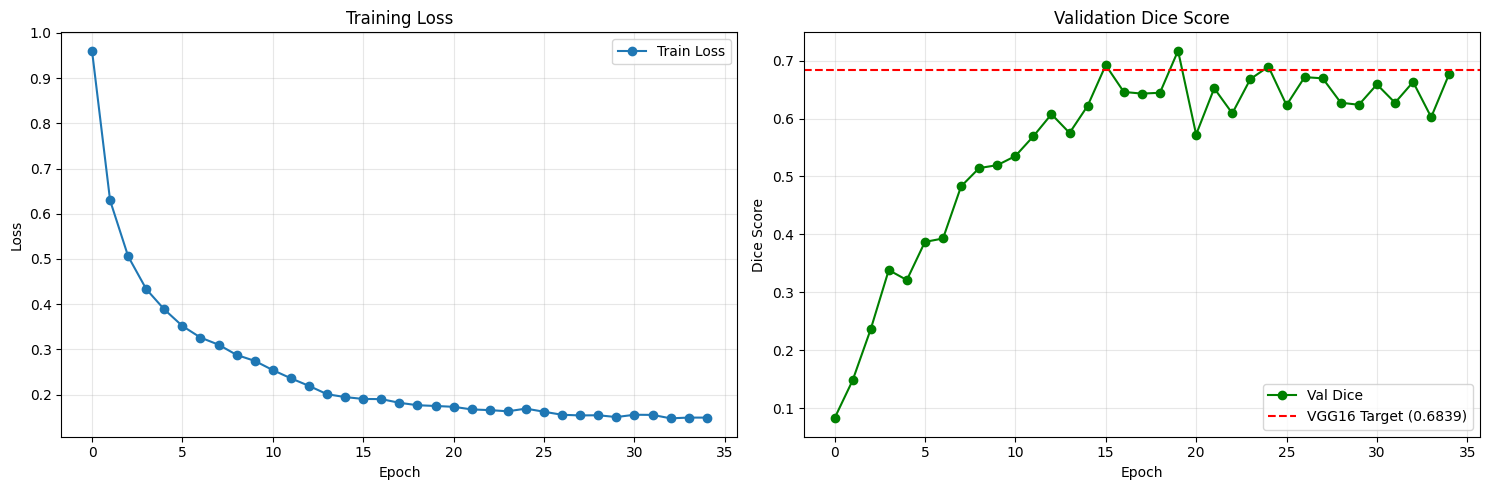

✅ Gráficos guardados


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice Score
axes[1].plot(history['val_dice'], label='Val Dice', marker='o', color='green')
axes[1].axhline(y=0.6839, color='r', linestyle='--', label='VGG16 Target (0.6839)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Validation Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'training_history_{ARCHITECTURE}_{ENCODER}_rd.png', dpi=150)
plt.show()

print(f"✅ Gráficos guardados")

## PASO 16: Evaluación Final

In [ ]:
import cv2
import numpy as np
import os

# 1. Define Colors (RGB)
# Background: Black, MA: Red, HE: Green, EX: Blue, SE: Yellow, OD: Cyan
COLORS = np.array([
    [0, 0, 0],       # Background
    [255, 0, 0],     # MA
    [0, 255, 0],     # HE
    [0, 0, 255],     # EX
    [255, 255, 0],   # SE
    [0, 255, 255]    # OD
], dtype=np.uint8)

# 2. Define Class Names
CLASS_NAMES = ['Background', 'MA', 'HE', 'EX', 'SE', 'OD']

# 3. Helper Function to Load and Combine Masks
def load_full_gt_categorical(img_name, lesion_folders, target_size=(1024, 1024)):
    """
    Loads individual lesion masks and combines them into a single categorical mask.

    Args:
        img_name (str): Filename of the original image (e.g., 'IDRiD_01.jpg')
        lesion_folders (dict): Dictionary mapping lesion types to folder paths.
        target_size (tuple): Target size (width, height) for resizing.

    Returns:
        full_mask (np.array): Categorical mask (H, W) with values 0-5.
    """
    # Initialize empty mask (Background = 0)
    # Note: target_size for cv2 is (width, height), but numpy shape is (height, width)
    # Since we use 1024x1024 square, the order matches.
    full_mask = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)

    base_name = img_name.replace('.jpg', '')

    # Lesion types and their class indices
    # Order allows later classes to overwrite earlier ones in case of overlap
    lesion_types = ['MA', 'HE', 'EX', 'SE', 'OD']

    for i, lesion_type in enumerate(lesion_types):
        class_idx = i + 1  # 1 to 5
        folder = lesion_folders.get(lesion_type)

        if folder:
            # Construct standard filename (e.g., IDRiD_01_MA.tif)
            filename = f"{base_name}_{lesion_type}.tif"
            mask_path = os.path.join(folder, filename)

            if os.path.exists(mask_path):
                # Load as grayscale
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if mask is not None:
                    # Resize to match target size (nearest neighbor to preserve classes)
                    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

                    # Update full_mask: set pixels where mask > 0 to class_idx
                    full_mask[mask > 0] = class_idx

    return full_mask

print("✅ Visualization helpers defined:")
print(f"   COLORS: {COLORS.shape}")
print(f"   CLASS_NAMES: {CLASS_NAMES}")
print("   Function: load_full_gt_categorical")

✅ Visualization helpers defined:
   COLORS: (6, 3)
   CLASS_NAMES: ['Background', 'MA', 'HE', 'EX', 'SE', 'OD']
   Function: load_full_gt_categorical



### Recargar los pesos de los mejores modelos


In [ ]:
import os
import torch

model_path = 'best_unet_efficientnet-b3_rd.pth'

if os.path.exists(model_path):
    print(f"📥 Loading model from {model_path}...")
    # Use the global DEVICE variable defined earlier
    # Explicitly set weights_only=False to allow loading the full checkpoint dictionary
    checkpoint = torch.load(model_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Model reloaded successfully.")
    print(f"   Epoch: {checkpoint['epoch']}")
    print(f"   Best Val Dice: {checkpoint['dice_score']:.4f}")
else:
    print(f"❌ Error: Model file '{model_path}' not found.")

📥 Loading model from best_unet_efficientnet-b3_rd.pth...
✅ Model reloaded successfully.
   Epoch: 19
   Best Val Dice: 0.7172


### Código para Visualización de Imágenes Completas


▶️ Visualizing results (Normalized) for: ['IDRiD_55', 'IDRiD_56', 'IDRiD_58', 'IDRiD_81']


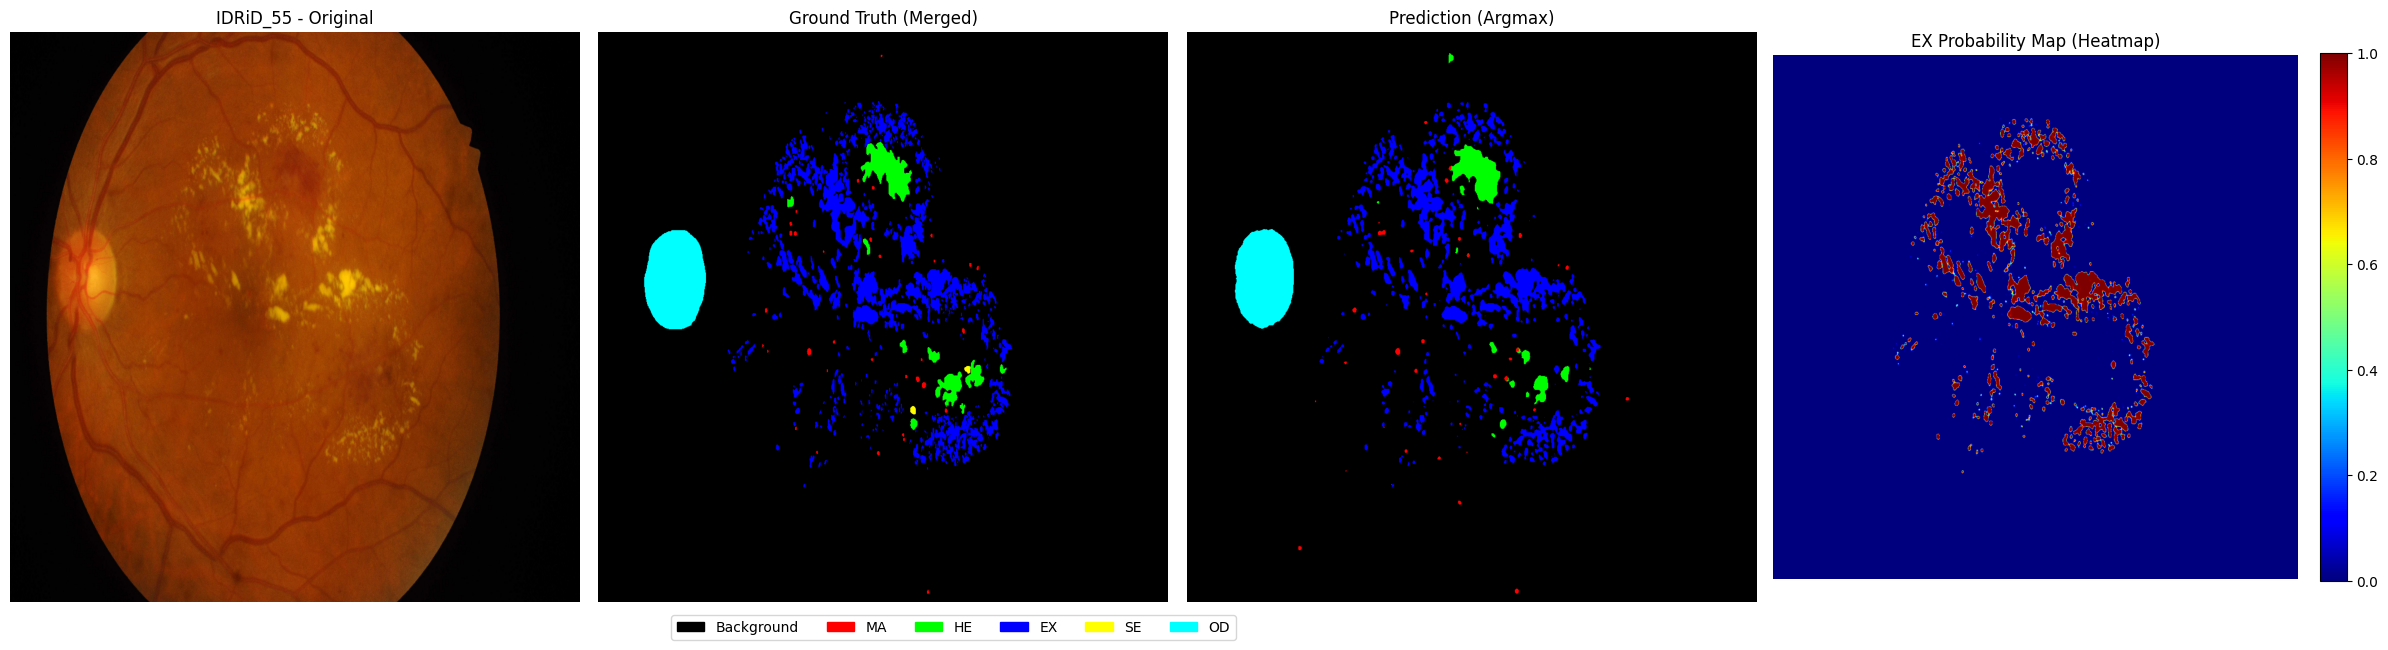

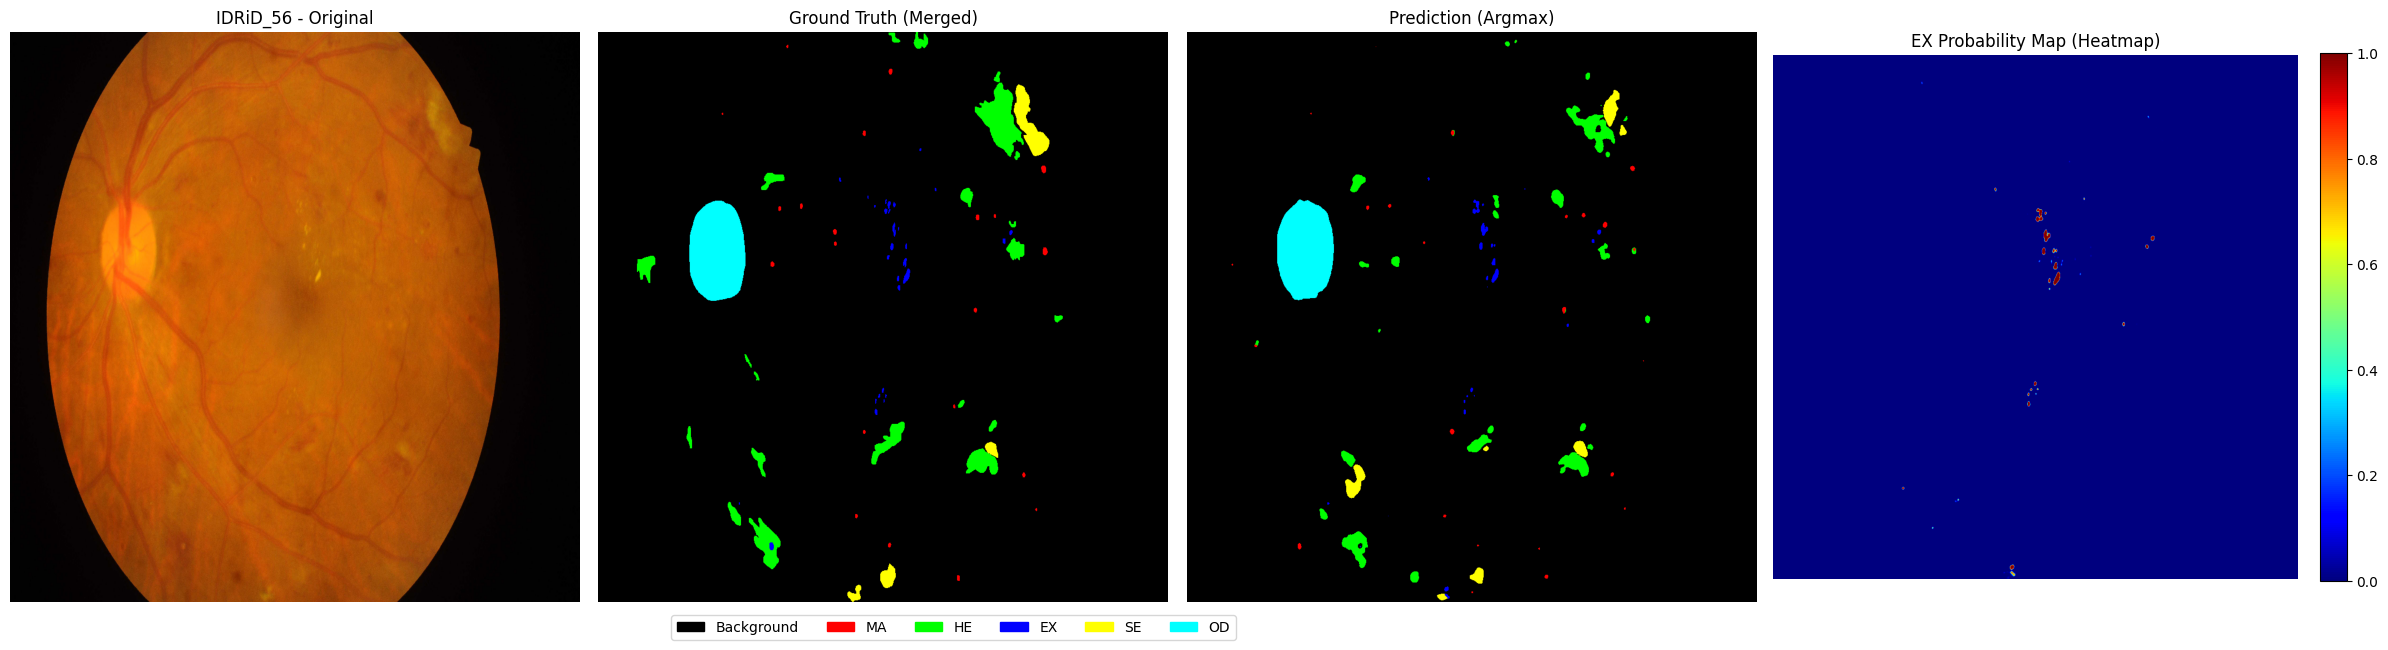

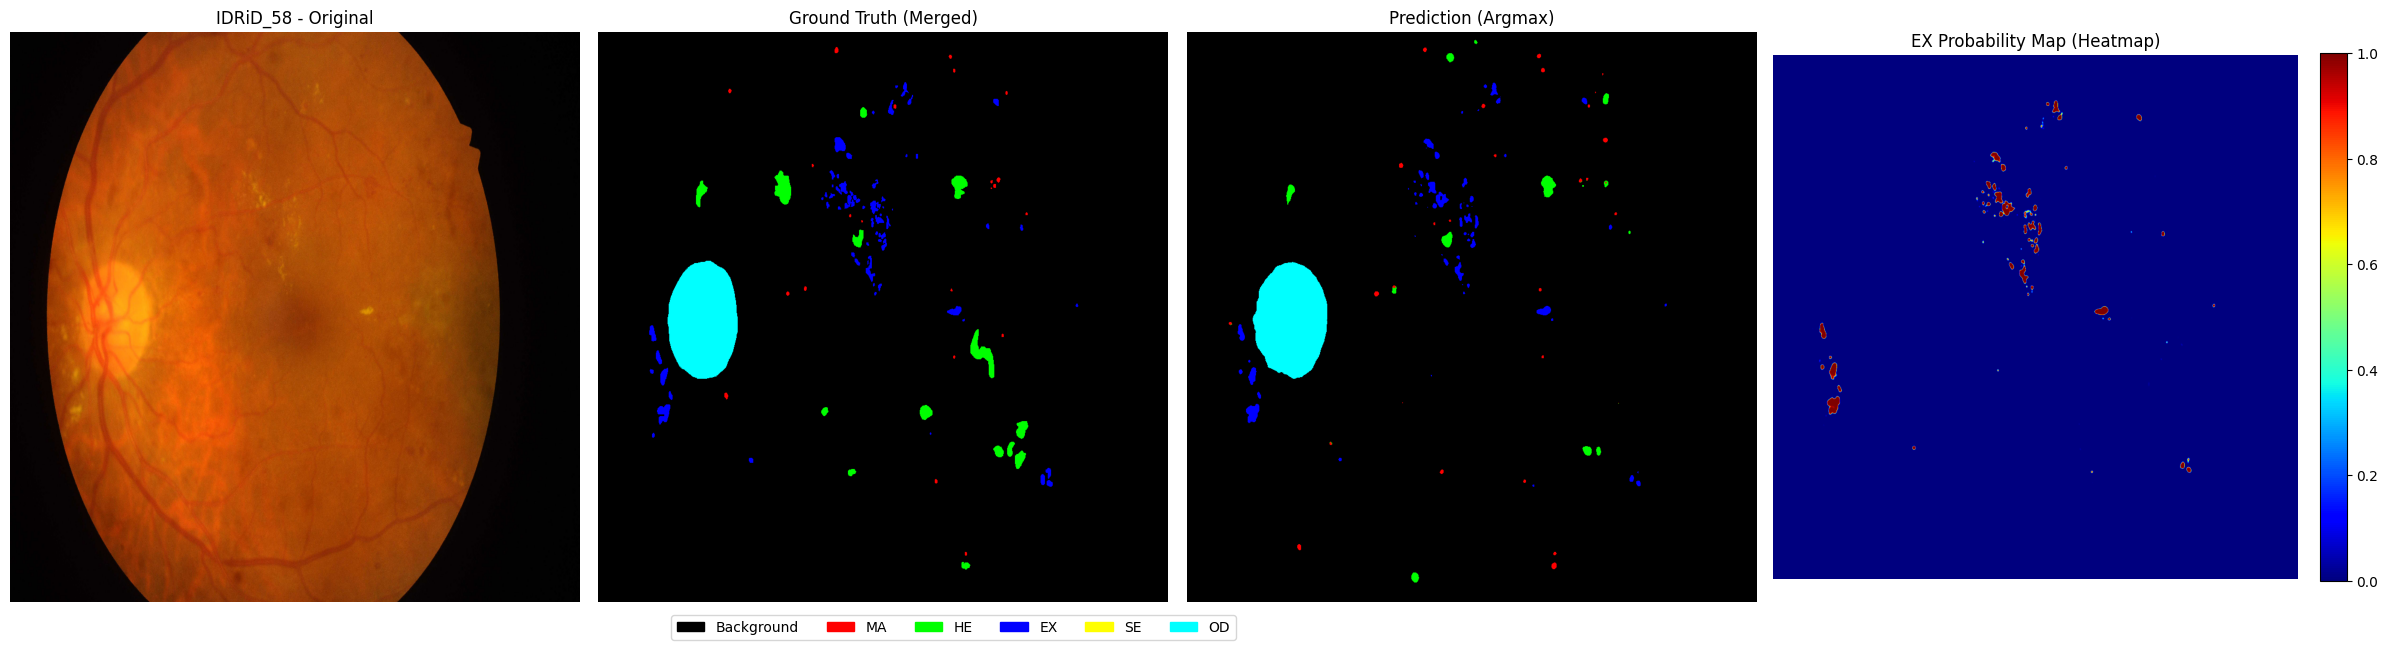

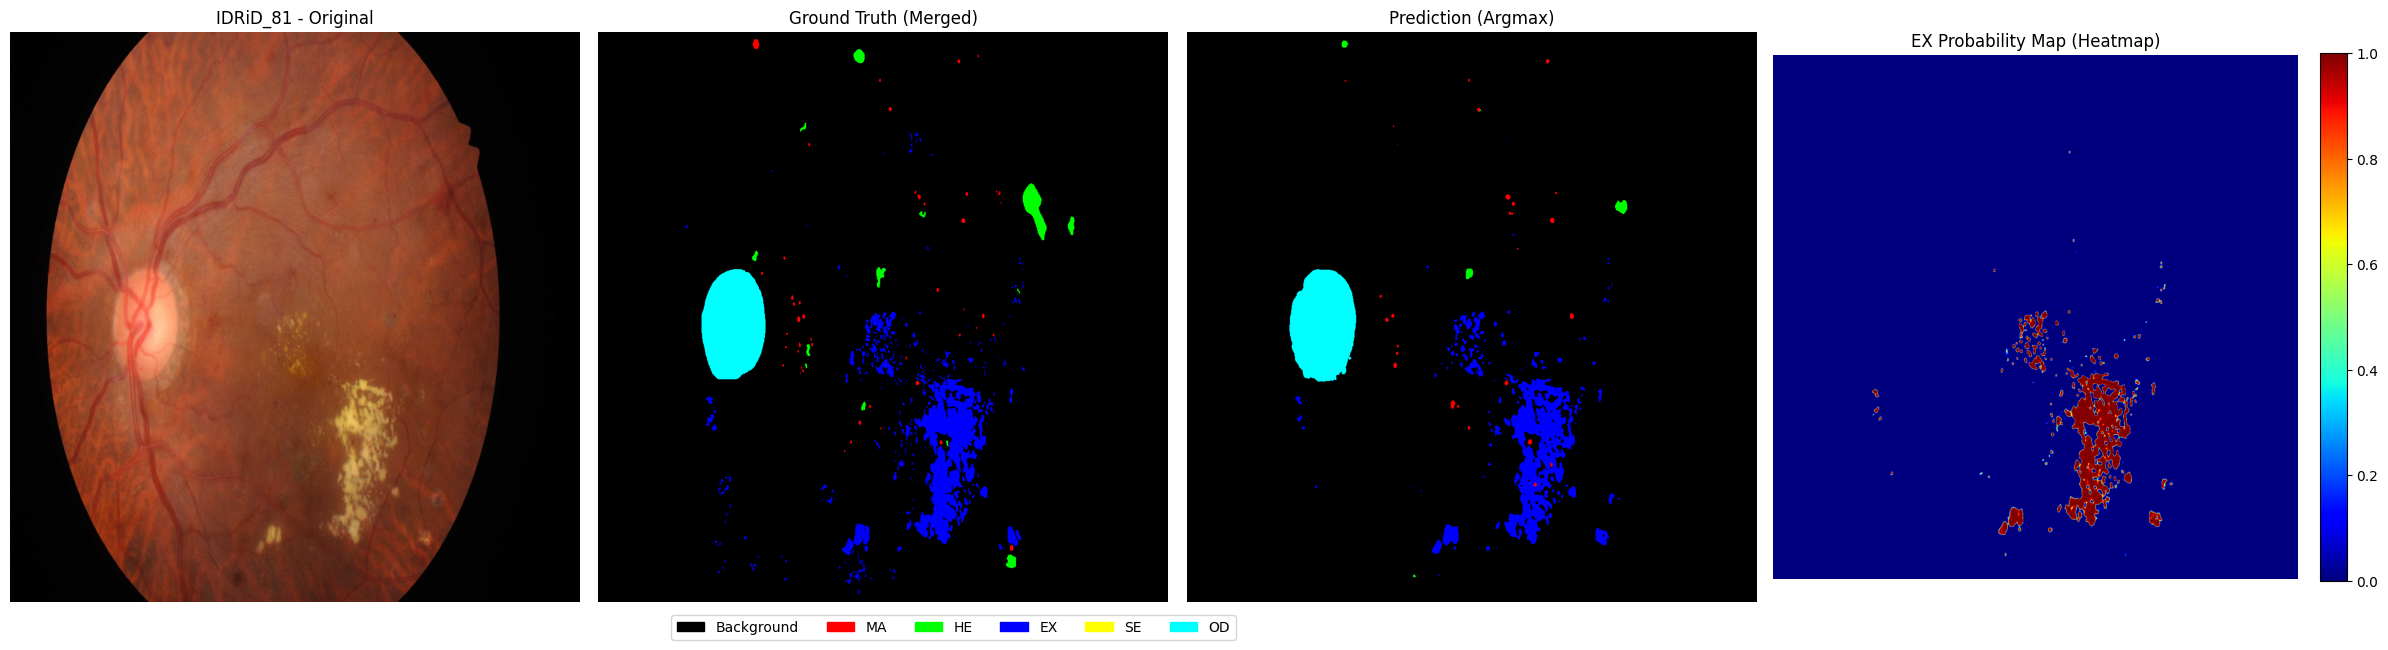

In [ ]:
import matplotlib.patches as mpatches

def debug_full_image_improved(model, device, test_img_dir, test_lesion_folders, img_names_to_test):
    """
    Visualizes Input, Ground Truth (Categorical), Prediction (Categorical Argmax),
    and Raw Probability Map for EX (Hard Exudates).

    Applies strict ImageNet normalization.
    """
    model.eval()
    target_size = (1024, 1024)

    # ImageNet stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Legend patches
    patches = [mpatches.Patch(color=COLORS[i]/255.0, label=CLASS_NAMES[i])
               for i in range(len(CLASS_NAMES))]

    for base_name in img_names_to_test:
        img_filename = f"{base_name}.jpg"
        img_path = os.path.join(test_img_dir, img_filename)

        if not os.path.exists(img_path):
            print(f"❌ Image not found: {img_path}")
            continue

        # 1. Load and Preprocess Image
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, target_size)

        # Normalize (Strict ImageNet)
        img_float = original_img.astype(np.float32) / 255.0
        img_norm = (img_float - mean) / std

        # To Tensor
        input_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float()
        input_tensor = input_tensor.to(device)

        # 2. Predict
        with torch.no_grad():
            output = model(input_tensor) # (1, 6, 1024, 1024)

            # Categorical prediction (Argmax)
            pred_categorical = torch.argmax(output, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

            # EX Probability Map (Class index 3)
            # Output is sigmoid activated in this model
            ex_prob_map = output[0, 3, :, :].cpu().numpy()

        # 3. Load Ground Truth
        gt_categorical = load_full_gt_categorical(img_filename, test_lesion_folders, target_size)

        # 4. Colorize
        gt_colored = COLORS[gt_categorical]
        pred_colored = COLORS[pred_categorical]

        # 5. Plot
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))

        # Original
        axes[0].imshow(original_img)
        axes[0].set_title(f"{base_name} - Original")
        axes[0].axis('off')

        # GT
        axes[1].imshow(gt_colored)
        axes[1].set_title(f"Ground Truth (Merged)")
        axes[1].axis('off')

        # Prediction (Argmax)
        axes[2].imshow(pred_colored)
        axes[2].set_title(f"Prediction (Argmax)")
        axes[2].axis('off')

        # EX Probability
        im3 = axes[3].imshow(ex_prob_map, cmap='jet', vmin=0, vmax=1)
        axes[3].set_title(f"EX Probability Map (Heatmap)")
        axes[3].axis('off')
        plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

        # Legend
        fig.legend(handles=patches, loc='lower center', ncol=6, bbox_to_anchor=(0.4, -0.05))
        plt.tight_layout()
        plt.show()

# Run the improved visualization
img_names = ["IDRiD_55", "IDRiD_56", "IDRiD_58", "IDRiD_81"]
print(f"\n▶️ Visualizing results (Normalized) for: {img_names}")
debug_full_image_improved(model, DEVICE, TEST_IMG_DIR, TEST_LESION_FOLDERS, img_names)

### Calculo de Precision y Recall

📊 Calculando Precision y Recall...


Calculando métricas (P/R): 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


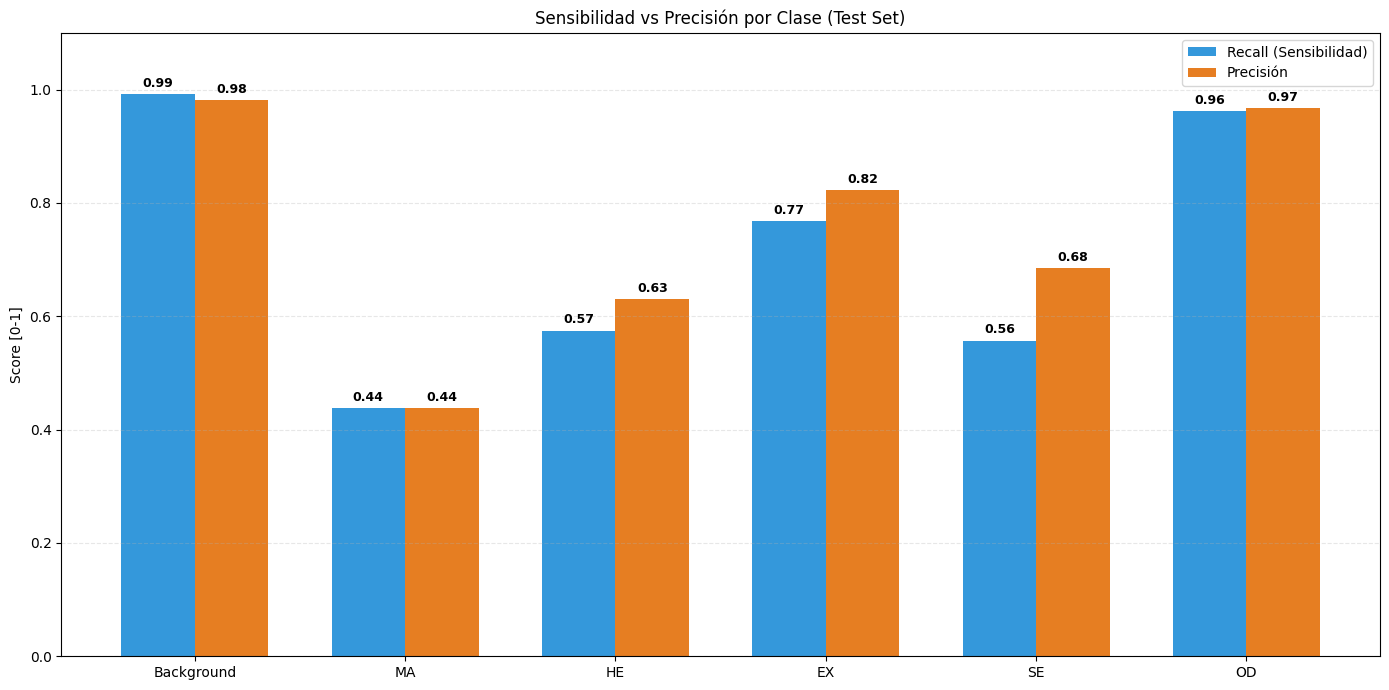


Clase            Recall  Precisión   F1-Score
---------------------------------------------
Background       0.9914     0.9813     0.9863
MA               0.4375     0.4383     0.4379
HE               0.5748     0.6310     0.6016
EX               0.7673     0.8226     0.7940
SE               0.5571     0.6848     0.6144
OD               0.9622     0.9668     0.9645



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def calculate_precision_recall(model, dataloader, device, num_classes=6):
    """
    Calcula Precision y Recall por clase acumulando TP, FP, FN sobre todo el dataset.
    """
    model.eval()

    # Inicializar contadores para cada clase
    total_tp = torch.zeros(num_classes).to(device)
    total_fp = torch.zeros(num_classes).to(device)
    total_fn = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Calculando métricas (P/R)"):
            images = images.to(device)
            masks = masks.to(device)

            # Predicción
            outputs = model(images)  # Sigmoid output
            preds = (outputs > 0.5).float()

            # Calcular TP, FP, FN por batch (sumando sobre H, W y Batch)
            # masks shape: (B, 6, H, W)
            tp = (preds * masks).sum(dim=(0, 2, 3))
            fp = (preds * (1 - masks)).sum(dim=(0, 2, 3))
            fn = ((1 - preds) * masks).sum(dim=(0, 2, 3))

            total_tp += tp
            total_fp += fp
            total_fn += fn

    # Calcular métricas (con epsilon para evitar división por cero)
    epsilon = 1e-7
    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)

    return precision.cpu().numpy(), recall.cpu().numpy()

# 1. Calcular Métricas
print("📊 Calculando Precision y Recall...")
precision_scores, recall_scores = calculate_precision_recall(model, val_loader, DEVICE, NUM_CLASSES)

# 2. Visualizar Resultados
class_names = ['Background', 'MA', 'HE', 'EX', 'SE', 'OD']
x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, recall_scores, width, label='Recall (Sensibilidad)', color='#3498db')
rects2 = ax.bar(x + width/2, precision_scores, width, label='Precisión', color='#e67e22')

# Estilizado
ax.set_ylabel('Score [0-1]')
ax.set_title('Sensibilidad vs Precisión por Clase (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Etiquetas de valor sobre las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# 3. Imprimir Tabla Detallada
print("\n" + "="*45)
print(f"{'Clase':<12s} {'Recall':>10s} {'Precisión':>10s} {'F1-Score':>10s}")
print("-"*45)

for i, name in enumerate(class_names):
    p = precision_scores[i]
    r = recall_scores[i]
    f1 = 2 * (p * r) / (p + r + 1e-7)
    print(f"{name:<12s} {r:10.4f} {p:10.4f} {f1:10.4f}")
print("="*45 + "\n")

###Calculo de IoU Scores

📊 Calculando IoU Scores...


Calculando IoU: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]


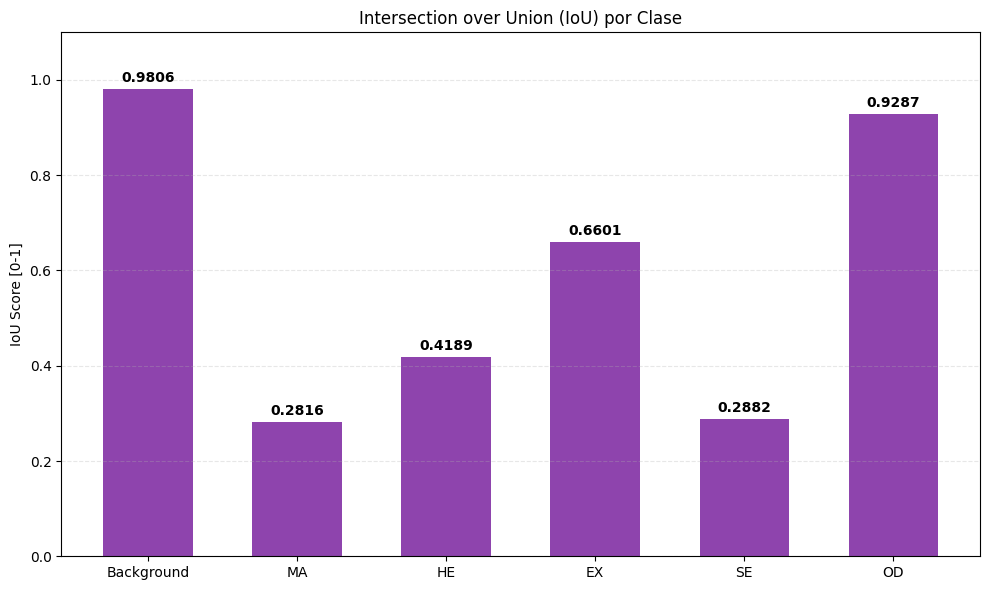


Clase         IoU Score
------------------------------
Background       0.9806
MA               0.2816
HE               0.4189
EX               0.6601
SE               0.2882
OD               0.9287



In [ ]:
def calculate_iou_per_class(model, dataloader, device, num_classes=6):
    """
    Calcula IoU (Jaccard Index) por clase acumulando TP, FP, FN sobre todo el dataset.
    IoU = TP / (TP + FP + FN)
    """
    model.eval()

    total_tp = torch.zeros(num_classes).to(device)
    total_fp = torch.zeros(num_classes).to(device)
    total_fn = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Calculando IoU"):
            images = images.to(device)
            masks = masks.to(device)

            # Predicciones
            outputs = model(images)
            preds = (outputs > 0.5).float()

            # Calcular TP, FP, FN acumulados
            tp = (preds * masks).sum(dim=(0, 2, 3))
            fp = (preds * (1 - masks)).sum(dim=(0, 2, 3))
            fn = ((1 - preds) * masks).sum(dim=(0, 2, 3))

            total_tp += tp
            total_fp += fp
            total_fn += fn

    # Calcular IoU global por clase
    epsilon = 1e-7
    iou = total_tp / (total_tp + total_fp + total_fn + epsilon)

    return iou.cpu().numpy()

# 1. Calcular IoU
print("📊 Calculando IoU Scores...")
iou_scores = calculate_iou_per_class(model, val_loader, DEVICE, NUM_CLASSES)

# 2. Visualizar Resultados
class_names = ['Background', 'MA', 'HE', 'EX', 'SE', 'OD']
x = np.arange(len(class_names))

fig, ax = plt.subplots(figsize=(10, 6))
rects = ax.bar(x, iou_scores, width=0.6, color='#8e44ad', label='IoU Score')

# Estilizado
ax.set_ylabel('IoU Score [0-1]')
ax.set_title('Intersection over Union (IoU) por Clase')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Etiquetas
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects)
plt.tight_layout()
plt.show()

# 3. Tabla
print("\n" + "="*30)
print(f"{'Clase':<12s} {'IoU Score':>10s}")
print("-"*30)
for i, name in enumerate(class_names):
    print(f"{name:<12s} {iou_scores[i]:10.4f}")
print("="*30 + "\n")